# RETEST  DenseNet121 - sans augmentation de données ni fine-tuning

| **Model**       | **Original Input Shape** | **Training Input Shape** | **Source Image Size** |
|---------------|------------------------|-------------------------|----------------------|
| **DenseNet121**  | 224×224 | 224×224 | **500×500** |

Pourquoi ? pour confirmer que cas **256×256** n'a **pas eu impact**

| **Model**       | **Original Input Shape** | **Training Input Shape** | **Source Image Size** |
|---------------|------------------------|-------------------------|----------------------|
| **DenseNet121**  | 224×224 | 224×224 | **256×256** |

### Case to Retest:  
### **DenseNet121 without Data Augmentation or Fine-Tuning**

- **No Data Augmentation (Only Normalization):**  
  ```python
  train_datagen = ImageDataGenerator(rescale=1./255)
  valid_datagen = ImageDataGenerator(rescale=1./255
 ```  **
- **Without fine-tuning**, you **should** completely **freeze all layers** of the pre-trained model (e.g., DenseNet121) and **only** train the **newly added** classification layers.
- **Original Input Shape**:The input size required by the **pre-trained** model on ****ImageNet 224x224**. This is the size it was originally trained on.                                 

- Training Input Shape :**target_size**  used for training (defined by target_size in flow_from_directory). Sometimes different from the original input shape 
-**Batch Size**: **64**
- **Epochs**: **40**
- **Earlystopping** :to prevent overfitting
                                     
***Ancien NB de ce model `notebooks/modeling/image/Old_5Top_models_WOut_data_Aug_or_F-Tunning/Iteration_#3_DenseNet121_All_Train_data_02122021_40Epochs_Accuracy_61.45%`***



## 1. Import Required Libraries 

In [2]:
# Désactiver les avertissements
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Modules système et gestion de fichiers
import os
import sys
import glob
import pickle
from datetime import datetime
from pathlib import Path
import importlib
import itertools
import re

# Manipulation des données
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

# Barre de progression
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

# Machine Learning & Évaluation des modèles
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, 
    classification_report
)
from sklearn import metrics
from scikeras.wrappers import KerasClassifier

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras import backend as K, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    Embedding, Dense, Dropout, Flatten, Activation, 
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
    GlobalAveragePooling1D, RNN, GRUCell
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

# Modèles pré-entraînés Keras
from tensorflow.keras.applications import  DenseNet121 

# from tensorflow.keras.applications.vgg16 import preprocess_input

# Prétraitement des images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sauvegarde et chargement des modèles
from joblib import dump, load
from keras.utils import np_utils


### Setting Up Project Paths and Configurations

In [3]:
# Get the current notebook directory
CURRENT_DIR = Path(os.getcwd()).resolve()

# Automatically find the project root (go up 2 level)
PROJECT_ROOT = CURRENT_DIR.parents[2]

# Add project root to sys.path
sys.path.append(str(PROJECT_ROOT))

# Function to get relative paths from project root
def get_relative_path(absolute_path):
    return str(Path(absolute_path).relative_to(PROJECT_ROOT))

# Print project root directory
print(f"Project Root Directory: {PROJECT_ROOT.name}")  # Display only the root folder name

import config  # Now Python can find config.py
importlib.reload(config)  # Reload config to ensure any updates are applied


Project Root Directory: Data_Scientist_Rakuten_Project-main


<module 'config' from 'D:\\Data_Science\\Append_Data_Engineer_AWS_MLOPS\\Data_Scientist_Rakuten_Project-main\\config.py'>

## 2. Import Preprocessed Data



In [4]:
importlib.reload(config)  # Reload config to ensure any updates are applied

#  Define the path for the training dataset
train_pickle_path = Path(config.XTRAIN_FINAL_ENCODED_PATH)
images_dir_train_path = Path(config.RAW_IMAGE_TRAIN_DIR)

#  Function to get relative paths from the project root
def get_relative_path(absolute_path: Path):
    """Returns the relative path from the project root."""
    return str(absolute_path.relative_to(config.BASE_DIR))

#  Function to load a Pickle file safely
def load_pickle(file_path: Path, dataset_name: str):
    """Loads a pickle file with error handling and basic visualization."""
    if not file_path.exists():
        print(f"[X] Error: `{dataset_name}` file not found at {file_path}")
        return None

    try:
        data = pd.read_pickle(file_path)
        print(f"[✔] Successfully loaded `{dataset_name}` | Shape: {data.shape}")
        
        # Display first rows if dataset is not empty
        if not data.empty:
            display(data.head(5))

        return data
    except Exception as e:
        print(f"[X] Error loading `{dataset_name}`: {e}")
        return None

#  Check if the required file exists before loading
if not train_pickle_path.exists():
    raise FileNotFoundError(f"[X] Error: `Training Dataset` file not found at {get_relative_path(train_pickle_path)}")

#  Load the training dataset
X_train_im = load_pickle(train_pickle_path, "X_train_final_encoded.pkl")


[✔] Successfully loaded `X_train_final_encoded.pkl` | Shape: (84916, 9)


,designation,description,productid,imageid,prdtypecode,prdtypecode_encoded,Label,image_name,text
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,<NA>,3804725264,1263597046,10,0,Adult Books,image_1263597046_product_3804725264.jpg,olivia personalisiertes notizbuch seiten punkt...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,<NA>,436067568,1008141237,2280,1,Magazines,image_1008141237_product_436067568.jpg,journal arts art marche salon art asiatique pa...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,2,Video Games Accessories,image_938777978_product_201115110.jpg,grand stylet ergonomique bleu gamepad nintendo...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,<NA>,50418756,457047496,1280,3,Toys for Children,image_457047496_product_50418756.jpg,peluche donald europe disneyland marionnette d...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,4,Books,image_1077757786_product_278535884.jpg,guerre tuques luc idees grandeur veut organise...


## 2. Data Preparation

### 2.1  Splitting Data into Training and Testing Sets Needed?

<span style="color:red"><b>⚠️ Attention : valeur random_state=1234 pour rester conforme aux anciennes implémentations testées il y a 3 ans.</b></span>


In [7]:
# # #If class_mode="sparse", y_col="prdtypecode_encoded" column values must be strings.
# # ImageDataGenerator/flow_from_dataframe
# X_train_full["prdtypecode_encoded"] = X_train_full["prdtypecode_encoded"].astype(str) 



# # Split Train set 
# X_train_im, X_test_im = train_test_split(X_train_full, train_size=0.8, random_state=1234)

# print(f"Split Completed:")
# print(f"X_train_im shape: {X_train_im.shape}")
# print(f"X_test_im shape: {X_test_im.shape}")

# print(f"Split Samples")
# print(f"X_train_im :")
# display(X_train_im.head(2))
# print(f"X_test_im :")
# display(X_test_im.head(2))

### 2.2 Data Preprocessing for Image Classification Using ImageDataGenerator

#### 2.2.1: Initializing Data Generators

In [8]:
importlib.reload(config)  # Reload config to ensure any updates are applied
images_dir_train_path = Path(config.RAW_IMAGE_TRAIN_DIR)

# #If class_mode="sparse", y_col="prdtypecode_encoded" column values must be strings.
# ImageDataGenerator/flow_from_dataframe
X_train_im["prdtypecode_encoded"] = X_train_im["prdtypecode_encoded"].astype(str) 



# # Générateur de données pour l'entraînement (Data Augmentation)
# # Ce générateur applique des transformations pour augmenter la diversité des images
# train_datagen = ImageDataGenerator(
#     rescale=1/255,              # Normalisation des pixels entre [0,1]
#     shear_range=0.2,            # Transformation en cisaillement
#     rotation_range=45,          # Rotation aléatoire entre -45° et +45°
#     width_shift_range=0.1,      # Décalage horizontal aléatoire (10% de l'image)
#     height_shift_range=0.1,     # Décalage vertical aléatoire (10% de l'image)
#     zoom_range=0.2,             # Zoom aléatoire entre -20% et +20%
#     horizontal_flip=True,       # Flip horizontal aléatoire
#     vertical_flip=True          # Flip vertical aléatoire
# )

# Générateur de données pour la validation (Pas d'augmentation)
# Seule la normalisation est appliquée pour que les images correspondent au modèle
# Générateur de données SANS augmentation (uniquement normalisation)
train_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = 0.2)
# valid_datagen = ImageDataGenerator(rescale=1./255)


#### 2.2.2 Creating Data Iterators for Training and Validation

In [9]:
IMG_ROWS = 224
IMG_COLS = 224
BATCH_SIZE = 64
EPOCHS = 40

#### 2.2.2.1  Itérateur pour l'entraînement (Chargement des images depuis un DataFrame) - Train

In [18]:
%%time
# Itérateur pour l'entraînement (Chargement des images depuis un DataFrame)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train_im,             # DataFrame contenant les chemins d'images
    directory=images_dir_train_path,       # Dossier où sont stockées les images
    as_ext=True,                      # Utilisation des extensions d’image (ex: .jpg, .png)
    x_col='image_name',                # Colonne contenant les chemins des images
    y_col='prdtypecode_encoded',              # Colonne contenant les labels (cible)
    class_mode='sparse',              # Mode sparse (labels sous forme d’entiers)
    target_size=(IMG_ROWS, IMG_COLS), # Redimensionnement des images pour correspondre au modèle
    batch_size=BATCH_SIZE,            # Nombre d'images par batch
    shuffle=True,                      # Mélange des données pour éviter l’apprentissage d’un ordre spécifique
    subset = 'training',
)

Found 67933 validated image filenames belonging to 27 classes.
Wall time: 7.95 s


#### 2.2.2.2  Itérateur pour la validation (Chargement des images sans transformation) - Valid

In [17]:
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train_im,              # DataFrame contenant les chemins d'images de validation
    directory=images_dir_train_path,       # Dossier où sont stockées les images
    as_ext=True,                      # Utilisation des extensions d’image
    x_col='image_name',                # Colonne contenant les chemins des images
    y_col='prdtypecode_encoded',              # Colonne contenant les labels (cible)
    class_mode='sparse',              # Mode sparse (labels sous forme d’entiers)
    target_size=(IMG_ROWS, IMG_COLS), # Redimensionnement des images
    batch_size=BATCH_SIZE,            # Nombre d'images par batch
    shuffle=False,                     # Pas de mélange pour assurer la cohérence des évaluations
    subset  = 'validation'
)

Found 16983 validated image filenames belonging to 27 classes.


## 3. DenseNet121 Implementation

In [12]:
%%time

# Chargement du modèle DenseNet121
denseNet121 = DenseNet121(weights='imagenet', include_top = False, input_shape=(IMG_ROWS,IMG_COLS,3))

# Correct for "without fine-tuning"
# Completely freeze all layers
for layer in denseNet121.layers:
    layer.trainable = False
    
    
model = Sequential()
model.add(denseNet121)
# Ajout des couche de classification 
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024,activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 512, activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 27, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

## 4. Model Compilation, Training, and Evaluation

### Model Compilation

In [13]:
%%time
# Compilation du modèle
model.compile(loss='sparse_categorical_crossentropy',  # Fonction de perte adaptée aux labels encodés
              optimizer='adam',                        # Algorithme de descente de gradient (Adam est souvent efficace par défaut)
              metrics=['accuracy'])                    # Suivi de l'accuracy pendant l'entraînement




Wall time: 13.8 ms


###  Callbacks

In [22]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

importlib.reload(config) 

#   Définition du chemin et du nom du fichier modèle
model_filename = "checkpoint_DenseNet121_{}.h5".format(pd.Timestamp.now().strftime("%Y%m%d-%H%M%S"))  # Ajout timestamp pour éviter d’écraser d’anciens fichiers
model_path = os.path.join(config.IMAGE_MODELS_DIR, model_filename)  # Chemin complet du fichier

#  Sauvegarde du meilleur modèle au cours de l'entraînement
checkpoint = ModelCheckpoint(filepath=model_path,  
                             monitor='val_accuracy',  # Surveiller l'accuracy sur la validation
                             verbose=1,
                             save_best_only=True,  # Sauvegarde uniquement le meilleur modèle
                             save_weights_only=True,  # Sauvegarde uniquement les poids (optimisation espace)
                             mode='max',  # 'max' car on veut maximiser l'accuracy
                             save_freq='epoch')  # Sauvegarde après chaque epoch

#  Arrêt automatique si la validation loss n'évolue plus
early = EarlyStopping(monitor='val_loss',
                      min_delta=0,  # Seuil minimum d'amélioration avant de considérer un arrêt
                      patience=5,  # Arrêt après 5 epochs sans amélioration
                      restore_best_weights=True,  # Recharge les meilleurs poids avant arrêt
                      verbose=1,
                      mode='min')  # 'min' car on veut minimiser la loss

### Model Training

In [23]:
step_size_Train = train_generator.n//train_generator.batch_size
step_size_Valid = valid_generator.n//valid_generator.batch_size
print('step_size_Train : ' , step_size_Train)
print('step_size_Valid  : ' , step_size_Valid)

step_size_Train :  1061
step_size_Valid  :  265


In [24]:
%%time
#  Entraînement du modèle
history = model.fit(train_generator,                    
                    epochs=EPOCHS,                   
                    steps_per_epoch=step_size_Train,  # Nombre de batchs par epoch pour l'entraînement
                    validation_data=valid_generator, # Jeu de validation
                    validation_steps=step_size_Valid,  # Nombre de batchs par epoch pour la validation
                    callbacks=[checkpoint, early])  # Callbacks pour gérer la sauvegarde et l'arrêt précoce


Epoch 1/40
1061/1061 [==============================] - ETA: 0s - loss: 1.7600 - accuracy: 0.4775
Epoch 1: val_accuracy improved from -inf to 0.53054, saving model to D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\image\checkpoint_DenseNet121_20250226-183244.h5
1061/1061 [==============================] - 403s 369ms/step - loss: 1.7600 - accuracy: 0.4775 - val_loss: 1.5466 - val_accuracy: 0.5305
Epoch 2/40
1061/1061 [==============================] - ETA: 0s - loss: 1.4934 - accuracy: 0.5531
Epoch 2: val_accuracy improved from 0.53054 to 0.56910, saving model to D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\image\checkpoint_DenseNet121_20250226-183244.h5
1061/1061 [==============================] - 333s 313ms/step - loss: 1.4934 - accuracy: 0.5531 - val_loss: 1.4212 - val_accuracy: 0.5691
Epoch 3/40
1061/1061 [==============================] - ETA: 0s - loss: 1.3832 - accuracy: 0.5793
Epoch 3: val_ac

### 4.3 Saving the Trained Model

In [25]:
importlib.reload(config)  # Reload config to ensure any updates are applied
from datetime import datetime  # Import datetime for timestamp

# Define model name prefix (Change this for different architectures)
MODEL_NAME = "X_RETEST_DenseNet121__224x224_500x500"  # Example: "gru_model", "lstm_model", etc.

# Ensure the directory exists before saving the model
os.makedirs(config.NEURAL_MODELS_DIR, exist_ok=True)

# Get current date and time in YYYYMMDD-HHMM format
timestamp = datetime.now().strftime("%Y%m%d-%H%M")

# Retrieve the number of epochs completed
if 'history' in globals():
    num_epochs = len(history.epoch)  # Actual trained epochs
else:
    num_epochs = "unknown"

# Define a compact filename with model name, epochs, and timestamp
model_filename = f"{MODEL_NAME}_E{EPOCHS}-T{num_epochs}_{timestamp}.h5"

# Full path for saving the model
model_path = os.path.join(config.IMAGE_MODELS_DIR, model_filename)

# Print the path where the model will be saved
print(f"Saving the model to: {model_path}")

try:
    # Save the trained Keras model (in .h5 format)
    model.save(model_path)

    print(f"Model saved successfully as {model_filename}")

except Exception as e:
    # Print error message if saving fails
    print(f"Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\image\X_RETEST_DenseNet121__224x224_500x500_E40-T13_20250226-1953.h5
Model saved successfully as X_RETEST_DenseNet121__224x224_500x500_E40-T13_20250226-1953.h5


### 4.4 Load the saved Trained Model (Optional)

In [ ]:
importlib.reload(config)  #Reload config to apply any updates

# Ask the user for the model name to load
model_name = "xxxxxx.h5"  # Change this to the desired model filename

# Define the full path to the model
model_path = os.path.join(config.IMAGE_MODELS_DIR, model_name)

# Check if the model file exists
if os.path.exists(model_path):
    # Load the trained Keras model
    model = tf.keras.models.load_model(model_path)
    print(f"✔ Model loaded successfully from: {model_path}")
else:
    print(f"[X] Model file not found at: {model_path}")

### 4.5 Model Evaluation on the Test Set

#### 4.5.1 Learning Rate Curve

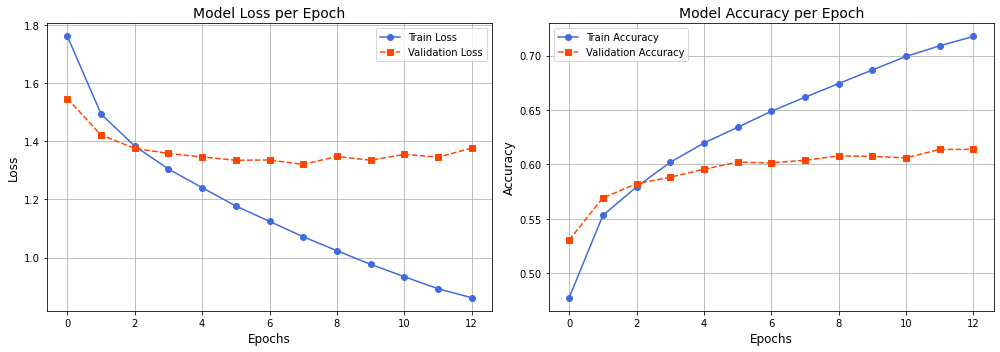

In [39]:
import matplotlib.pyplot as plt

# Définition des couleurs pour harmoniser les courbes
train_color = 'royalblue'
valid_color = 'orangered'

# Création de la figure avec une meilleure disposition
plt.figure(figsize=(14, 5))

# Courbe de Loss
plt.subplot(1, 2, 1)  # (1 ligne, 2 colonnes, premier plot)
plt.plot(history.history['loss'], color=train_color, linestyle='-', marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], color=valid_color, linestyle='--', marker='s', label='Validation Loss')
plt.title('Model Loss per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

#  Courbe d'Accuracy
plt.subplot(1, 2, 2)  # (1 ligne, 2 colonnes, deuxième plot)
plt.plot(history.history['accuracy'], color=train_color, linestyle='-', marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color=valid_color, linestyle='--', marker='s', label='Validation Accuracy')
plt.title('Model Accuracy per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Affichage
plt.tight_layout()  # Ajuste l'espacement pour éviter les chevauchements
plt.show()


#### 4.5.2  Prédictions sur l’ensemble de validation

In [40]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Extraire les vraies étiquettes depuis le valid_generator
y_true = valid_generator.classes  # Les étiquettes de validation

# Faire les prédictions sur l'ensemble de validation
y_pred_proba = model.predict(valid_generator)  # Probabilités des classes
y_pred_classes = np.argmax(y_pred_proba, axis=1)  # Convertir en classes prédictes

# Vérification des dimensions
assert len(y_true) == len(y_pred_classes), "Mismatch in validation labels and predictions!"


266/266 [==============================] - 75s 279ms/step


 #### 4.5.3 Calcul des métriques (F1-score, classification report)

In [41]:
# Calcul du F1-score pondéré (prend en compte les classes déséquilibrées)
val_f1 = f1_score(y_true, y_pred_classes, average='weighted', zero_division=0)

# Afficher le F1-score
print(f"[✔] Validation Weighted F1-Score: {val_f1:.4f}")

# Afficher le rapport de classification
print("\n[✔] Classification Report:")
print(classification_report(y_true, y_pred_classes, zero_division=0))


[✔] Validation Weighted F1-Score: 0.5966

[✔] Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.57      0.54       621
           1       0.73      0.62      0.67       956
           2       0.61      0.61      0.61       939
           3       0.68      0.55      0.61       546
           4       0.74      0.88      0.81      2061
           5       0.37      0.29      0.32       154
           6       0.64      0.72      0.67      1020
           7       0.50      0.50      0.50       290
           8       0.84      0.91      0.87       791
           9       0.45      0.52      0.48      1021
          10       0.48      0.47      0.48       483
          11       0.68      0.77      0.72       163
          12       0.50      0.33      0.40       375
          13       0.51      0.40      0.45       656
          14       0.44      0.37      0.40       508
          15       0.39      0.41      0.40       168
          16

 #### 4.5.4 Matrice de confusion

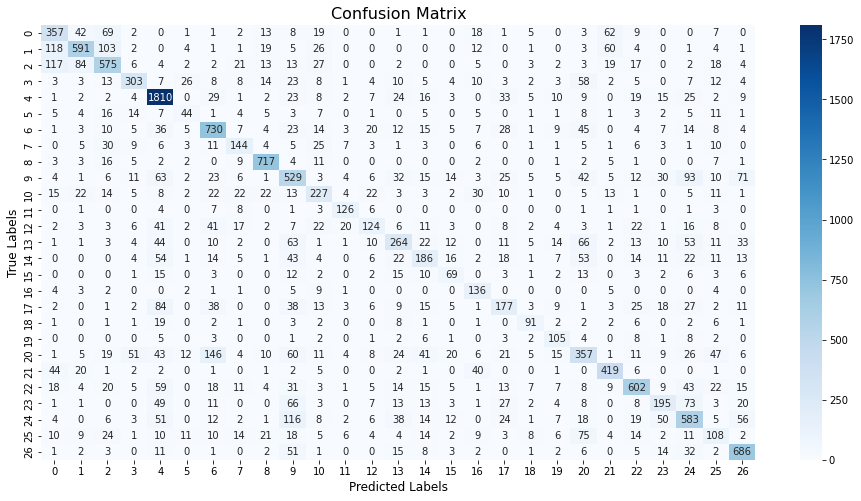

In [42]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Affichage de la matrice de confusion avec heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(27), yticklabels=np.arange(27))

# Ajout des titres et labels
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Affichage de la matrice
plt.show()


## 6. Customized Model Performance Analysis

This section outlines our comprehensive evaluation of the model’s classification performance, structured as follows:

- **6.1 Customized Classification Report:**  
  We start by mapping the training class numbers to the original class numbers and labels, providing clarity on performance metrics across the original categories.

- **6.2 Classification Report Generation & Class Categorization:**  
  Here, we categorize classes based on their F1-scores using thresholds derived from the Rakuten benchmark (weighted F1-score = 0.8113). This approach helps us distinguish classes that are well-classified, moderately classified, or poorly classified, thereby pinpointing areas for targeted improvement.

- **6.3 Consolidated Misclassification Report:**  
  We then dive deeper into prediction errors with a multi-layered analysis that includes:  
  - **6.3.1 Confusion Matrix Visualization with Mapped Labels:** Visualizing misclassification patterns by aligning training class numbers with the original labels.  
  - **6.3.2 Breakdown of Misclassifications:** Identifying common misclassification trends and frequently confused classes.  
  - **6.3.3 Detailed Misclassification Statistics:** Providing error counts and misclassification rates to highlight areas where the model underperforms.

This structured approach allows us to quickly identify strengths and focus on specific areas for improvement.---


###  6.1 Customized Classification Report with Mapped Classes and Original Labels

In [ ]:
# import importlib
# import src.model_evaluation  # Initial import
# importlib.reload(config)  # Force reload the module
# importlib.reload(src.model_evaluation)  # Force reload the module

# from src.model_evaluation import process_classification_report
# # import config

# # Generate and process the classification report
# classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
#     y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
# )

# # Display accuracy separately
# print(f"\n[✔] Accuracy: {accuracy_value:.2f} (on {accuracy_support} samples)\n")

# # Display final classification summary
# print("\n[✔] Classification Summary Rows")
# display(summary_rows)

# # Display processed classification report
# print("\n[✔] Processed Classification Report with Mapped Classes and Original Labels")
# display(classification_df.tail(40))




### 6.2 Customized Classification Report Generation and  Class Categorization

To assess performance, classes are categorized based on their **F1-scores** using thresholds defined relative to the **Rakuten benchmark** (RNN on text data, weighted F1-score = **0.8113**). These thresholds are designed to pinpoint areas for improvement and align with industry standards:

- **Well-classified:** **F1 ≥ Benchmark (e.g., 0.80)** – Categories that perform on par with or better than the reference model.
- **Moderately classified:** **Threshold_lower ≤ F1 < Benchmark** – Categories that may require further refinement.
- **Poorly classified:** **F1 < Threshold_lower** – Categories with notable misclassification issues.

These thresholds are **customizable** and will be adjusted based on results from baseline models in this challenge.


In [ ]:
# import importlib
# import src.model_evaluation  # Initial import
# import src.display # Initial import

# importlib.reload(config)  # Force reload the module
# importlib.reload(src.model_evaluation)  # Force reload the module
# importlib.reload(src.display)  # Force reload the module
# from src.model_evaluation import analyze_classification_performance, process_classification_report
# from src.display import display_dataframe_to_user  # Import de la fonction

# # Generate and process the classification report
# classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
#     y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
# )


# # Define classification thresholds
# WELL_CLASSIFIED_THRESHOLD = 0.80
# MODERATELY_CLASSIFIED_THRESHOLD = 0.50

# # Run classification performance analysis with dynamic thresholds
# category_counts, well_classified, moderately_classified, poorly_classified = analyze_classification_performance(
#     classification_df, 
#     well_classified_threshold=WELL_CLASSIFIED_THRESHOLD, 
#     moderately_classified_threshold=MODERATELY_CLASSIFIED_THRESHOLD
# )

# # Display summary based on dynamic thresholds
# print("\n[✔] Summary of Classification Performance:")
# print(f"- {category_counts.get('Well-classified', 0)} classes have an F1-score ≥ {WELL_CLASSIFIED_THRESHOLD:.2f} (Well-classified)")
# print(f"- {category_counts.get('Moderate', 0)} classes have an F1-score between {MODERATELY_CLASSIFIED_THRESHOLD:.2f} and {WELL_CLASSIFIED_THRESHOLD:.2f} (Moderately classified)")
# print(f"- {category_counts.get('Poorly classified', 0)} classes have an F1-score < {MODERATELY_CLASSIFIED_THRESHOLD:.2f} (Poorly classified)")


# # Display detailed classification breakdown
# # If `display_rows` is None (default), the entire DataFrame is shown; otherwise, it limits to `display_rows`.
# display_dataframe_to_user(
#     name=f"Well-Classified Categories (F1 ≥ {WELL_CLASSIFIED_THRESHOLD:.2f})",
#     dataframe=well_classified.sort_values(by="f1-score", ascending=False), display_rows=None
# )

# display_dataframe_to_user(
#     name=f"Moderately Classified Categories ({MODERATELY_CLASSIFIED_THRESHOLD:.2f} ≤ F1 < {WELL_CLASSIFIED_THRESHOLD:.2f})",
#     dataframe=moderately_classified.sort_values(by="f1-score", ascending=False), display_rows=None
# )

# display_dataframe_to_user(
#     name=f"Poorly Classified Categories (F1 < {MODERATELY_CLASSIFIED_THRESHOLD:.2f})",
#     dataframe=poorly_classified.sort_values(by="f1-score", ascending=True),display_rows=None
# )



 ### 6.3 Consolidated Misclassification Report: Analyzing Prediction Errors

### 6.3.1 Confusion Matrix Visualization with Mapped Labels
→ Display the confusion matrix with mapped labels to visualize misclassification patterns.

In [ ]:
# import importlib
# importlib.reload(config)  # Reload config to ensure any updates are applied
# import src.model_evaluation  # Initial import

# importlib.reload(src.model_evaluation)  # Force reload the module
# from src.model_evaluation import generate_confusion_matrix  

# # Generate the confusion matrix with mapped labels
# conf_matrix_df_labeled = generate_confusion_matrix(y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH)

# # Display the confusion matrix as a heatmap
# plt.figure(figsize=(20, 12))
# sns.heatmap(conf_matrix_df_labeled, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix with Mapped Labels")
# plt.show()


### 6.3.2 Breakdown of Misclassifications  
→ **Analyze misclassification trends, identify the most frequently misclassified classes, and assess overall model performance.**  

In this section, we analyze the model’s misclassification patterns using a structured approach.  
We present four breakdowns to understand where the model struggles the most.  

#### **Columns in the Misclassification Table:**  
- **Encoded target** → The encoded numerical representation of each class.  
- **Original prdtypecode** → The original product category code.  
- **Class Label** → The human-readable label of the class.  
- **Samples** → The total number of instances for each class.  
- **Misclassified Count** → The number of misclassified samples for the class.  
- **Misclassification Rate (%)** → The percentage of misclassified samples within the class.  
- **Global Misclassification Rate (%)** → The percentage of misclassified samples relative to the total dataset.  

####  **Key Misclassification Perspectives**  

1. **Classes with the highest number of samples**  
   - Shows the most **frequent classes** in the dataset.  
   - Helps assess whether a class’s misclassification is due to **its high occurrence** or **its inherent difficulty**.  
   - Large classes can dominate misclassification counts even if their misclassification rate is low.  

2. **Classes with the highest number of misclassifications**  
   - Highlights the classes with the **largest absolute number of errors**.  
   - Useful for identifying which classes **contribute the most errors**, regardless of their misclassification rate.  
   - A class with many misclassifications may indicate **model weakness** or **data imbalance**.  

3. **Classes with the highest misclassification rate (%)**  
   - Identifies the classes where the model **struggles the most** proportionally.  
   - A high rate suggests **systematic confusion** in distinguishing this class from others.  
   - Small classes with a **high error rate** might require **better feature representation** or **more training data**.  

4. **Classes contributing the most to overall misclassification (%)**  
   - Measures **each class’s impact on total model errors**.  
   - A class with **many samples and a moderate error rate** can still contribute significantly to overall misclassification.  
   - Helps prioritize which classes should be improved to **reduce total model error** the most.  


By examining these four aspects, we gain insights into both **systematic classification errors** and **dataset imbalances** that could be influencing the model’s performance.  


In [ ]:
# import importlib

# importlib.reload(config)
# import src.model_evaluation  # Initial import
# importlib.reload(src.model_evaluation)
# from src.model_evaluation import analyze_and_display_misclassification

# # Calculs déjà réalisés
# misclassified_counts = conf_matrix_df_labeled.sum(axis=1) - np.diag(conf_matrix_df_labeled)
# total_samples_per_class = conf_matrix_df_labeled.sum(axis=1)
# misclassification_rates = round((misclassified_counts / total_samples_per_class) * 100, 2)

# # [✔]Call the function with a custom number of rows to display
# # You can set `display_rows` to control how many rows are shown in the notebook.
# # By default, it displays 10 rows.
# misclassification_analysis_df = analyze_and_display_misclassification(
#     y_test, y_pred_classes, misclassified_counts, total_samples_per_class, misclassification_rates, display_rows=10
# )


### 6.3.3 Detailed Misclassification Statistics  
→ **Analyze individual misclassification cases, including total errors, misclassification rates, and overprediction trends.**  

####  Meaning of Columns in the Classification Error Analysis Table  

| **Column**                | **Description** |
|---------------------------|----------------|
| **True Label**            | The actual class of the sample in the test set (the correct category). |
| **Predicted Label**       | The incorrect class predicted by the model instead of the **True Label**. |
| **Count**                 | The number of times samples from **True Label** were misclassified as **Predicted Label**. |
| **Percentage**            | The proportion of this specific misclassification relative to **all misclassified instances**. Computed as: `(Count / Total Misclassified) * 100`. |
| **Class Sample Size** | The total number of test samples belonging to the **True Label** class (i.e., how many instances of this class exist in the test set). |
| **Misclassified Count**   | The total number of **True Label** samples that were misclassified (sum of all errors for this class). |
| **Misclassification Rate** | The error rate for the **True Label** class. Computed as: `(Misclassified Count /Class Sample Size) * 100`. |
| **Total Predicted**       | The total number of test samples predicted as belonging to the **Predicted Label** class (both correctly and incorrectly). |
| **Incorrect Predictions** | The number of test samples **incorrectly predicted** as **Predicted Label** (should have been a different class). |
| **Overprediction Rate**   | The proportion of incorrect predictions for the **Predicted Label** class. Computed as: `(Incorrect Predictions / Total Predicted) * 100`. |



In [ ]:
# importlib.reload(config) 
# import src.model_evaluation  # Initial import
# importlib.reload(src.model_evaluation)  # Force reload to use updated functions
# from src.model_evaluation import generate_display_misclass_report

# # Generate the enriched misclassification report
# # NOTE: To display only a subset of rows, modify display_rows when calling the function
# # Example: Use display_rows=20 to show only the top 20 rows:
# misclassification_report = generate_display_misclass_report(
#     y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH, display_rows=20 # Set top_n to an integer (e.g., 20) to limit rows
# )

# # # Display the final enriched report
# # print("\n[✔] Consolidated Misclassification Report:")
# # display(misclassification_report)

### 6.4 **Exporting Classification Analysis to Excel** 

This step saves all classification insights into a **single Excel file** with multiple sheets for easy review.  

####  Exported Data Includes:
- **Well-Classified, Moderately Classified, Poorly Classified** categories (sorted by F1-score).  
- **Misclassification Analysis** (error rates, misclassified counts).  
- **Consolidated Misclassification Report** (detailed misclassification breakdown per class).  
- **Raw Confusion Matrix** (numerical values without labels).  

####  Output File Example:  
**`classification_analysis_<MODEL_NAME>_<TIMESTAMP>.xlsx`**  



In [ ]:

# # Generate and process the classification report
# classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
#     y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
# )
# print(type(classification_df))
# print(type(summary_rows))
# print(type(accuracy_value))
# print(type(accuracy_support))
    
# # Display processed classification report
# print("\n[✔] Processed Classification Report with Mapped Classes and Original Labels")
# display(classification_df.tail(5))

# # Display accuracy separately
# print(f"\n[✔] Accuracy: {accuracy_value:.2f} (on {accuracy_support} samples)\n")

# # Display final classification summary
# print("\n[✔] Classification Summary Rows")
# display(summary_rows.tail(5))


In [ ]:
# import importlib
# import src.model_evaluation  # Initial import
# import src.export_utils  # # Initial import

# importlib.reload(config) # Force reload module
# importlib.reload(src.model_evaluation)  # Force reload module
# importlib.reload(src.export_utils)  # Force reload module

# from src.model_evaluation import analyze_and_display_misclassification, generate_display_misclass_report
# from src.export_utils import export_all_analysis


# # Define model name and file prefix
# model_used = "GRU_Model"
# file_prefix = "classification_analysis"

# # Generate and process the classification report
# classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
#     y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
# )


# # Convert conf_matrix_df_raw to Pandas DataFrame
# conf_matrix_df = pd.DataFrame(conf_matrix_df_raw, 
#                               index=[f"True Class {label}" for label in set(y_test)],  # Index as True Labels
#                               columns=[f"Pred Class {label}" for label in set(y_pred_classes)])  # Columns as Predicted Labels



# # Generates and displays misclassification analysis
# full_misclassification_analysis_df = analyze_and_display_misclassification(y_test,
#                                                                            y_pred_classes,
#                                                                            misclassified_counts,
#                                                                            total_samples_per_class,
#                                                                            misclassification_rates,
#                                                                            display_rows=None,
#                                                                            display_output=False
# )

# #Generates and displays a comprehensive misclassification report combining multiple analyses
# full_misclassification_report = generate_display_misclass_report(y_test,
#                                                                  y_pred_classes,
#                                                                  config.PRDTYPECODE_MAPPING_PATH,
#                                                                  display_rows=None,
#                                                                 display_output=False
# )



# dataframes_to_export = {
#     "Class Categorization": {
#         f"Well-Classified (F1 ≥ {WELL_CLASSIFIED_THRESHOLD:.2f})": well_classified.sort_values(by="f1-score", ascending=False),
#         f"Moderately Classified ({MODERATELY_CLASSIFIED_THRESHOLD:.2f} ≤ F1 < {WELL_CLASSIFIED_THRESHOLD:.2f})": moderately_classified.sort_values(by="f1-score", ascending=False),
#         f"Poorly Classified (F1 < {MODERATELY_CLASSIFIED_THRESHOLD:.2f})": poorly_classified.sort_values(by="f1-score", ascending=True),
#     },
#     "Misclassification Analysis": full_misclassification_analysis_df,
#     "Consolidated Misclassification Report": full_misclassification_report,
#     "Raw Confusion Matrix": conf_matrix_df
# }

# # Export all the data
# export_path = export_all_analysis(
#     dataframes_dict=dataframes_to_export,
#     model_name=model_used,
#     file_prefix=file_prefix,
#     mode="text",
#     classification_df=classification_df,
#     summary_rows=summary_rows,
#     accuracy_value=accuracy_value,
#     accuracy_support=accuracy_support
# )

# # Print confirmation
# print(f"\n[✔] Full classification analysis saved to: {export_path}")

## 7. Hyperparameter Tuning (Optional – Depending on Time & Resources) 

### 7.1 Hyperparameter Search for GRU Cell Model using RandomizedSearchCV  

In this section, we perform **hyperparameter tuning** for the GRU-based text classification model using **RandomizedSearchCV**. Given computational constraints, we focus on optimizing only the **dropout rate** and **number of epochs**, while keeping other parameters fixed. This approach ensures an efficient search while maintaining model performance.  

#### **Fixed Hyperparameters:**  
- **Batch Size = 200**: Initial results showed stable performance with `batch_size=200`, making it a reliable choice.  

#### **Limited Hyperparameter Search:**  
- **Dropout Rate (0.2, 0.3)**: Helps control overfitting and improve generalization.  
- **Epochs (5, 8)**: Ensures training is not too short (underfitting) or too long (wasting resources).  

#### **Efficient Computation:**  
- **n_jobs=1**: Prevents system overload and excessive parallelization.  
- **cv=2**: Balances validation stability and computational cost.  
- **n_iter=4**: Covers all possible combinations of `dropout_rate` and `epochs`.  
- **Early Stopping**: Automatically stops training if validation accuracy doesn’t improve, optimizing resource usage.  


In [ ]:
# %%time

# # Function to create the model
# def create_model(dropout_rate=0.2, epochs=5):
#     model = Sequential()
#     model.add(Embedding(10000, 200))  # Embedding layer
#     model.add(RNN(GRUCell(128), return_sequences=True))  # GRU Layer (Fixed at 128 units)
#     model.add(Dropout(dropout_rate))  # Dropout layer
#     model.add(GlobalAveragePooling1D())  # Global Average Pooling
#     model.add(Dense(256, activation='relu'))  # Dense Layer
#     model.add(Dropout(dropout_rate))  # Dropout layer
#     model.add(Dense(27, activation='softmax'))  # Output Layer

#     # Use Adam optimizer with fixed learning rate
#     optimizer = Adam(learning_rate=0.001)

#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     return model


### 7.2 Retraining the GRUCell Model with Optimized Hyperparameters

In [ ]:
# %%time

# from scikeras.wrappers import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from tensorflow.keras.callbacks import EarlyStopping

# # Fixed batch size
# BATCH_SIZE = 200

# # Wrap the Keras model with Sci-Keras KerasClassifier
# model = KerasClassifier(model=create_model, verbose=0)

# # Define early stopping (stop training if val_accuracy doesn’t improve for 3 epochs)
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# # Hyperparameter grid to search (only dropout rate and epochs)
# param_dist = {
#     'model__dropout_rate': [0.2, 0.3],  # Pass as model__dropout_rate for KerasClassifier
#     'model__epochs': [5, 8],  # Pass as model__epochs
# }

# # Use RandomizedSearchCV for hyperparameter tuning
# random_search = RandomizedSearchCV(
#     estimator=model, 
#     param_distributions=param_dist, 
#     n_iter=4,  # Cover all possible combinations
#     cv=2,  # Reduce cross-validation folds for efficiency
#     verbose=2, 
#     n_jobs=-1  
# )

# # Fit the RandomizedSearchCV on the training data
# random_search.fit(X_train, y_train.values)

# # Print the best hyperparameters found
# print(f"Best Hyperparameters: {random_search.best_params_}")


 ### 7.3 Evaluating the Performance of the Best Model

In [ ]:
# # ==========================================================================================
# # Evaluate the Best Model Performance
# # ==========================================================================================

# # Make predictions on the test set
# y_pred_best = best_model.predict(X_test)
# y_pred_best = y_pred_best.argmax(axis=1)  # Convert one-hot or probability outputs to class labels if necessary

# # Compute evaluation metrics
# accuracy = accuracy_score(y_test, y_pred_best)
# weighted_f1 = f1_score(y_test, y_pred_best, average="weighted")

# # Print classification report
# print(f"[✔] Accuracy: {accuracy:.4f}")
# print(f"[✔] Weighted F1-Score: {weighted_f1:.4f}\n")
# print("Classification Report:\n", classification_report(y_test, y_pred_best))

# # Compute confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_best)

# # Plot the confusion matrix
# plt.figure(figsize=(18, 12))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(27), yticklabels=range(27))
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix for the Best GRU Cell Model")
# plt.show()


## 8. Conclusion